<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula09a_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:35<00:00, 24.7MB/s]
100% 812M/812M [00:35<00:00, 23.9MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" 
              for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, 
                      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape: ", data_batch.shape)
  print("labels batch shape: ", labels_batch.shape)
  break

data batch shape:  (32, 180, 180, 3)
labels batch shape:  (32,)


In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convner_from_scratch.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

In [11]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 17s 78ms/step - loss: 0.6971 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 5s 83ms/step - loss: 0.6917 - accuracy: 0.5300 - val_loss: 0.6821 - val_accuracy: 0.5730
Epoch 3/30
63/63 [==============================] - 6s 85ms/step - loss: 0.6750 - accuracy: 0.5890 - val_loss: 0.6701 - val_accuracy: 0.5460
Epoch 4/30
63/63 [==============================] - 6s 91ms/step - loss: 0.6411 - accuracy: 0.6290 - val_loss: 0.6289 - val_accuracy: 0.6450
Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6065 - accuracy: 0.6675 - val_loss: 0.6041 - val_accuracy: 0.6760
Epoch 6/30
63/63 [==============================] - 4s 61ms/step - loss: 0.5797 - accuracy: 0.6930 - val_loss: 0.6088 - val_accuracy: 0.6530
Epoch 7/30
63/63 [==============================] - 5s 74ms/step - loss: 0.5587 - accuracy: 0.7140 - val_loss: 0.6217 - val_accuracy: 0.6630
Epoch 8/30
6

In [13]:
test_model = keras.models.load_model("convner_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 34ms/step - loss: 0.5984 - accuracy: 0.6805
Test accuracy: 0.680


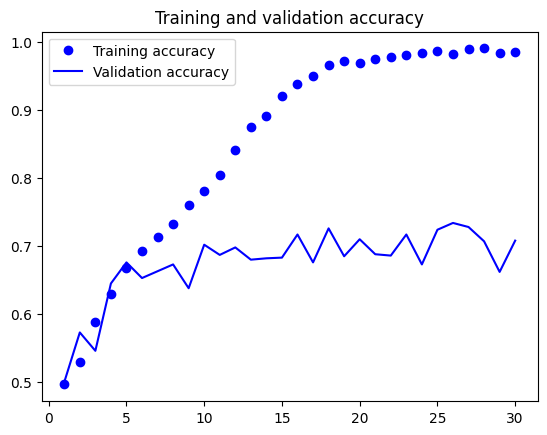

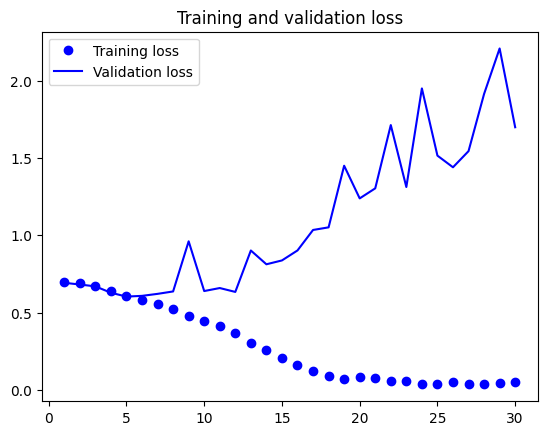

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

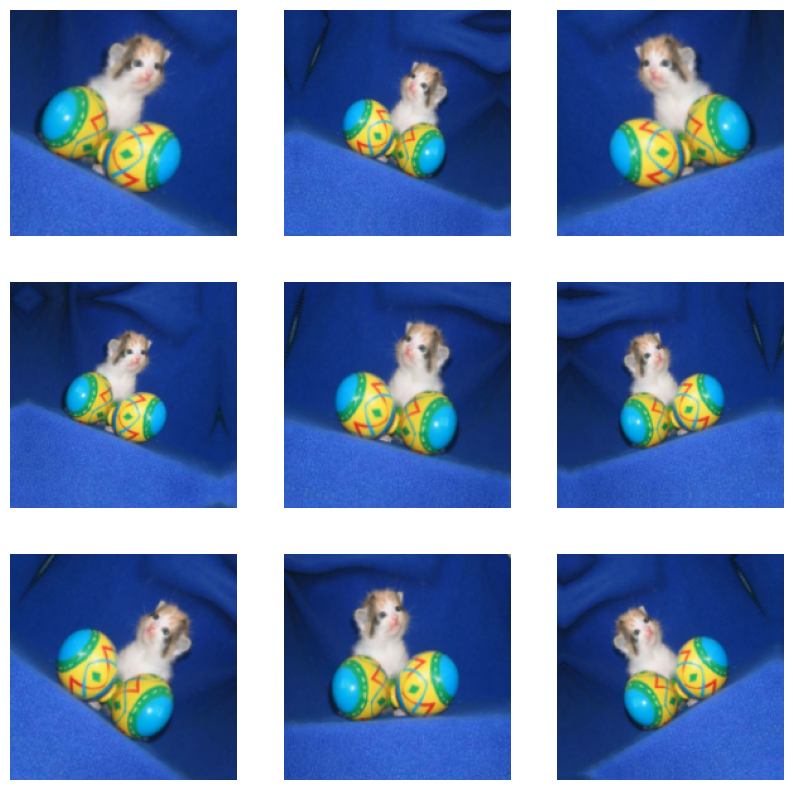

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
     

In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [20]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=100,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 86ms/step - loss: 0.6972 - accuracy: 0.4955 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 6s 85ms/step - loss: 0.6934 - accuracy: 0.5090 - val_loss: 0.6916 - val_accuracy: 0.5040
Epoch 3/100
63/63 [==============================] - 4s 65ms/step - loss: 0.6946 - accuracy: 0.5490 - val_loss: 0.6864 - val_accuracy: 0.5940
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.6659 - accuracy: 0.6080 - val_loss: 0.6332 - val_accuracy: 0.6380
Epoch 5/100
63/63 [==============================] - 5s 65ms/step - loss: 0.6413 - accuracy: 0.6405 - val_loss: 0.6774 - val_accuracy: 0.5860
Epoch 6/100
63/63 [==============================] - 4s 64ms/step - loss: 0.6249 - accuracy: 0.6415 - val_loss: 0.6193 - val_accuracy: 0.6380
Epoch 7/100
63/63 [==============================] - 6s 90ms/step - loss: 0.6062 - accuracy: 0.6545 - val_loss: 0.6215 - val_accuracy: 0.6620
Epoch 

In [21]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 33ms/step - loss: 0.4593 - accuracy: 0.8095
Test accuracy: 0.809


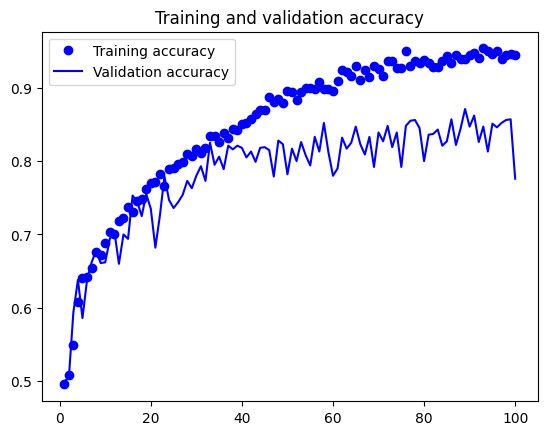

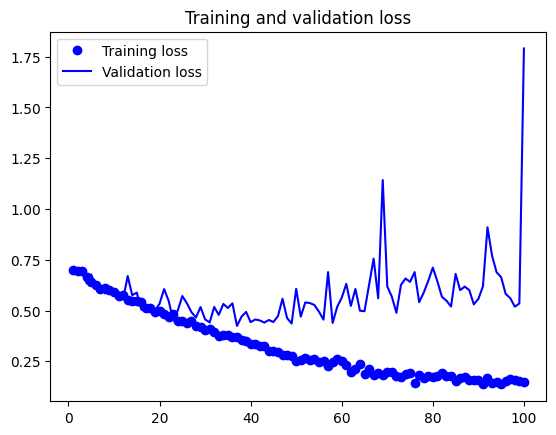

In [22]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()